# Machine Learning on the Titanic Dataset

This notebook focuses on one of [Kaggle's](https://www.kaggle.com/c/titanic) "Getting Started" prediction competitions, the Titanic challenge.

In [185]:
# classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# modules to handle data
import pandas as pd
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [186]:
# environment setup
sns.set()
plt.style.use('ggplot')
%matplotlib notebook

## I. Data Wrangling

Like in most cases with any data science project, we are likely to encounter dirty or missing data and will need to do some wrangling before we can really do anything else.

In [187]:
# load data
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

In [188]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [125]:
# save PassengerId for final submission
passengerId = test.PassengerId

# merge train and test
titanic = train.append(test, ignore_index=True)

In [126]:
# create indexes to separate data later on
train_idx = len(train)
test_idx = len(titanic) - len(test)

In [127]:
# view head of data
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [128]:
# get info on features
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [129]:
titanic.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

It looks like we have a few NaNs in the dataset across a few features. We will use the data to try and fill in the gaps. The `info()` method reveals that the `Age`, `Cabin`, `Embarked`, and `Fare` all have a few entries missing. Technically the `Survived` column also has entries missing, but this is actually correct since we merged the `train` and `test` together for future feature engineering and the test data doesn't have a `Survived` column.

Additionally, from looking at the features, it looks like we can just drop `PassengerId` from the dataset all together since it isn't really a helpful feature, but rather simply a row identifier.

In [189]:
# PassengerId can be removed from data for now
titanic.drop('PassengerId', axis=1, inplace=True)

KeyError: "['PassengerId'] not found in axis"

The first thing I want to do is parse out the `Name` column and extract the title's of each person's name so we can group the data according to a person's title. This will allow us to more accurately estimate other features in the next few steps. Technically this is more of a "feature engineering" step but it will help out in the data wrangling process so we include it here first.

In [190]:
# create a new feature to extract title names from the Name column
titanic['Title'] = titanic.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

# view the newly created feature
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,0.0,3,"Braund, Mr. Owen Harris",NaN,22.0,1,0,A/5 21171,7.2500,U,S,Mr,2
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",NaN,38.0,1,0,PC 17599,71.2833,C,C,Mrs,2
2,1.0,3,"Heikkinen, Miss. Laina",NaN,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",NaN,35.0,1,0,113803,53.1000,C,S,Mrs,2
4,0.0,3,"Allen, Mr. William Henry",NaN,35.0,0,0,373450,8.0500,U,S,Mr,1


In [132]:
# show count of titles
print("There are {} unique titles.".format(titanic.Title.nunique()))

# show unique titles
print("\n", titanic.Title.unique())

There are 18 unique titles.

 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


As we can see now, we have successfully extracted the title's from the name column. But if we inspect the titles a little more, we see some that can be normalized like "Capt" and "Col" for example are a type of "Officer" and "Mlle" is essentially the French version of "Miss". So now we will normalize these titles so we can cut down the number of titles even more.

In [133]:
# normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

In [134]:
# map the normalized titles to the current titles
titanic.Title = titanic.Title.map(normalized_titles)

# view value counts for the normalized titles
print(titanic.Title.value_counts())

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64


Great! We have shrunken our titles to 1/3 of the original titles after normalization.

For our next step, we are going to assume that their is a relationship between a person's age and their title since it makes sense that someone that is younger is more likely to be a titled a "Miss" vs a "Mrs".

With this in mind, we will group the data by `Sex`, `Pclass`, and `Title` and then view the `median` age for the grouped classes.

In [135]:
# group by Sex, Pclass, and Title
grouped = titanic.groupby(['Sex','Pclass', 'Title'])

# view the median Age by the grouped features
grouped.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Royalty    39.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Master      6.0
                Mr         41.5
                Officer    52.0
                Royalty    40.0
        2       Master      2.0
                Mr         30.0
                Officer    41.5
        3       Master      6.0
                Mr         26.0
Name: Age, dtype: float64

As expected, those passengers with a title of "Miss" tend to be younger than those titled "Mrs". Also, it looks like we have some age variability amongst the different passenger classes as well as between the sexes, so this should help us more accurately estimate the missing ages for the observations that do not have an age recorded.

In [136]:
# apply the grouped median value on the Age NaN
titanic.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

# view changes
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1309 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
 11  Title     1309 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 122.8+ KB


We were able to fill in the gaps for `Age` and now have 1309 records.

The next feature we will take a look at is `Cabin` and this one will be pretty simple. We will just fill in the NaNs with "U" for unknown.

In [137]:
# fill Cabin NaN with U for unknown
titanic.Cabin = titanic.Cabin.fillna('U')

Next up, for the 2 missing values for `Embarked`, we will simply fill it in with the most common port of embarkation.

In [138]:
# find most frequent Embarked value and store in variable
most_embarked = titanic.Embarked.value_counts().index[0]

# fill NaN with most_embarked value
titanic.Embarked = titanic.Embarked.fillna(most_embarked)

Lastly, we have just one missing `Fare` value so we will just fill it in with the `median` value.

In [139]:
# fill NaN with median fare
titanic.Fare = titanic.Fare.fillna(titanic.Fare.median())

# view changes
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1309 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1309 non-null   float64
 9   Cabin     1309 non-null   object 
 10  Embarked  1309 non-null   object 
 11  Title     1309 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 122.8+ KB


## II. Exploratory Data Analysis

Now we have a full and clean dataset that we can perform some exploratory analysis on. Probably the first thing we want to take a look at is what was the breakdown of those that died (0) vs those that survived (1) the Titanic?

In [140]:
# view the percentage of those that survived vs. those that died in the Titanic
titanic.Survived.value_counts(normalize=True)

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

Looks like only 38% of people onboard the Titanic managed to survive its fateful voyage.

Let's dig a little deeper and view survival chances by sex.

In [141]:
# group by sex
group_by_sex = titanic.groupby('Sex')

# survival rate by sex
group_by_sex.Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

For those of use who are familiar with the fateful story of the Titanic or who have seen the movie, we know that women and children had priority for life boats so these numbers aren't all that surprising. Even knowing that, it is still quite astounding to see that almost 75% of women survived the sinking of the Titanic while only 19% of men did.

Finally, let's break it down even further by Passenger Class and Sex.

In [142]:
# group by passenger class and sex
group_class_sex = titanic.groupby(['Pclass', 'Sex'])

# survival rates by class and sex
group_class_sex.Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

It appears that 1st class females had an incredible 97% survival rate while 1st class males only still had a 37% chance of survival. Even though you only had a 37% chance of surviving as a 1st class male, you still were almost 3 times _more_ likely to survive than a 3rd class male who had the lowest survival rate amongst sex _and_ class at 13.5%.

To get a better understanding for this, let's take a look at these figures visually with some graphs. We will first take a look at the `Survived` feature by `Sex`.

<IPython.core.display.Javascript object>


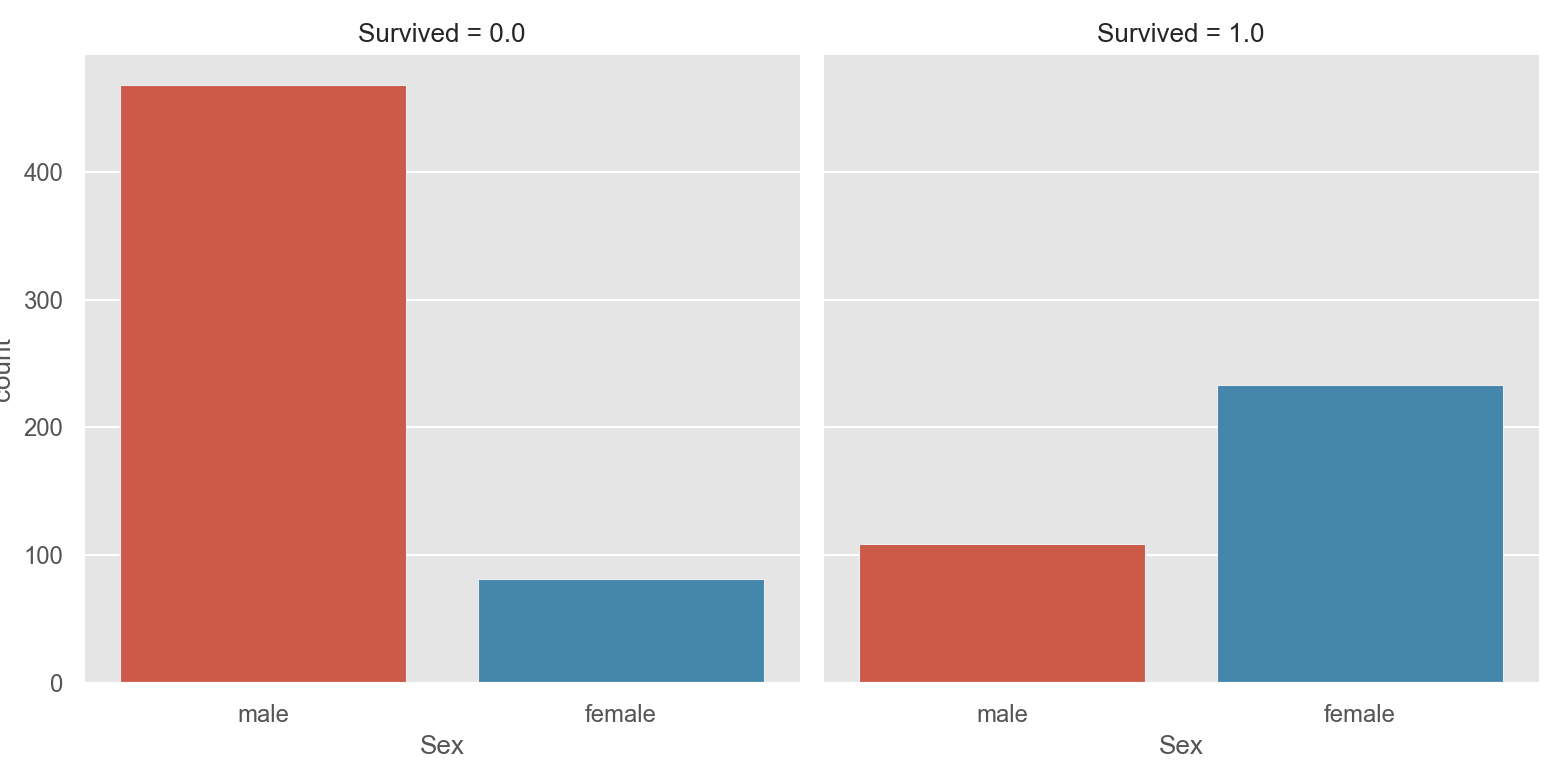

In [143]:
# plot by Survivded, Sex
_ = sns.factorplot(x='Sex', col='Survived', data=titanic, kind='count')

As we had already seen, the proportion of men to women that died was dramatically in favor of women. Less than 100 women died in comparison to well over 400 men.

Let's look at the graph broken down by `Pclass`.

<IPython.core.display.Javascript object>


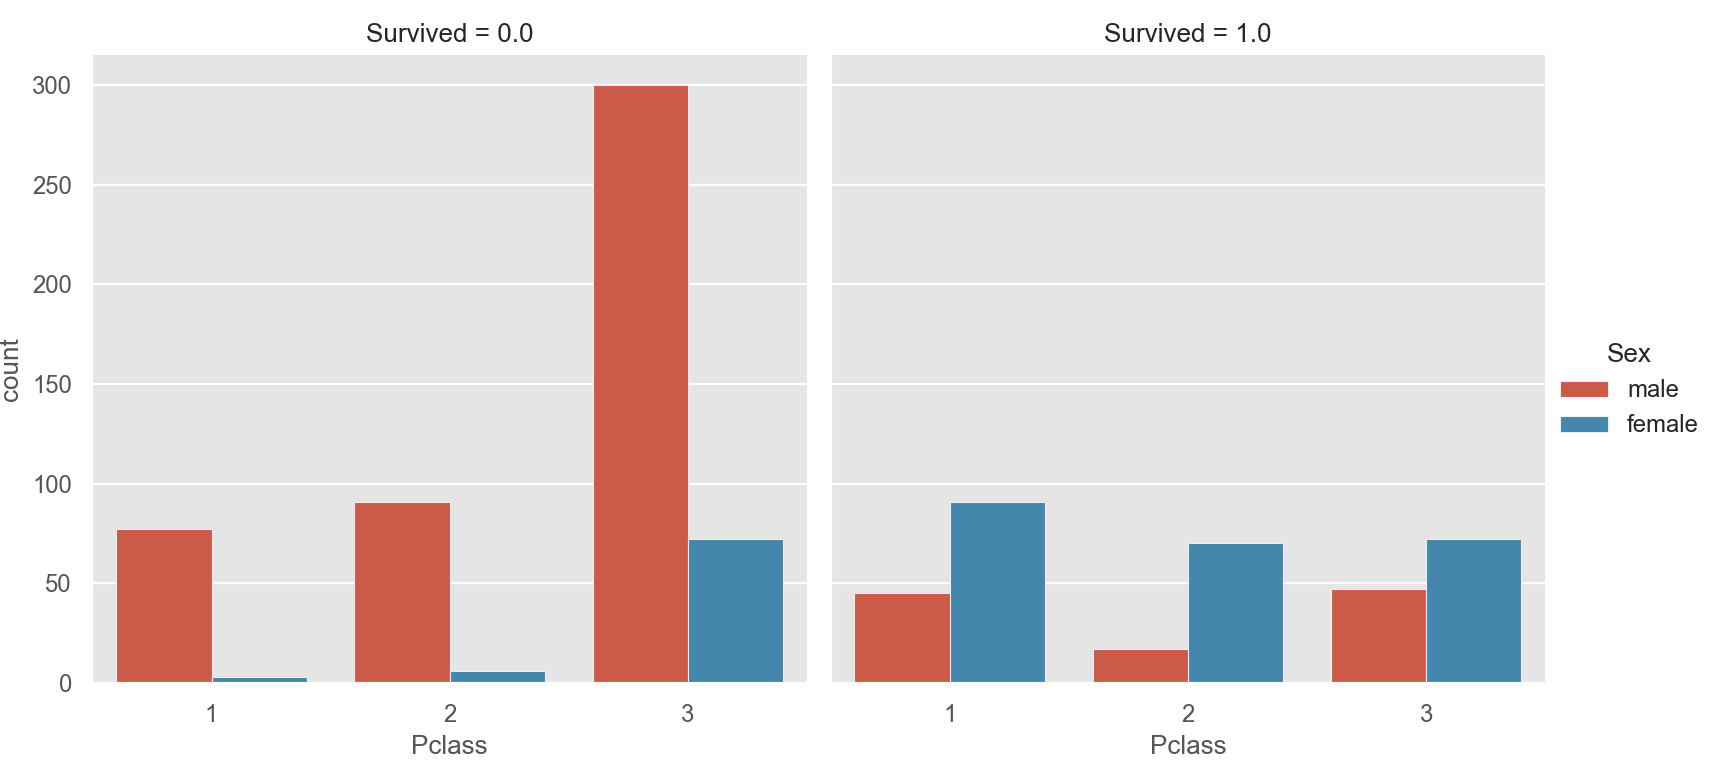

In [144]:
# plot by Pclass, Sex, Survived
_ = sns.factorplot(x='Pclass', hue='Sex', col='Survived', data=titanic, kind='count')

The social status is pretty clear on your chances of surviving.

Lastly, let's get a feel for some of the other metrics.

In [145]:
# get stats on all the features
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.383838,2.294882,29.278205,0.498854,0.385027,33.281086
std,0.486592,0.837836,13.446690,1.041658,0.865560,51.741500
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,36.500000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


## III. Feature Engineering

Now, let's go ahead and create a few new features from the data. The first feature we will look at building is `FamilySize`. This is important to look at because we want to see if having a large or small family affected someone's chances of survival.

The relevant features that will help with this are `Parch` (number of parents/children aboard) and `SibSp` (number of siblings/spouses aboard). We combine the `Parch` and `SibSp` features and add 1 as well as we want to count the passenger for each observation.

In [146]:
# size of families (including the passenger)
titanic['FamilySize'] = titanic.Parch + titanic.SibSp + 1

The `Cabin` feature itself as it stands now doesn't really provide all that useful information. However, we can extract the first letter and in that way, we would have a grouped set of cabins that could potentially reveal any effect on survival.

In [147]:
# map first letter of cabin to itself
titanic.Cabin = titanic.Cabin.map(lambda x: x[0])

# view normalized count
titanic.Cabin.value_counts(normalize=True)

U    0.774637
C    0.071811
B    0.049656
D    0.035141
E    0.031322
A    0.016807
F    0.016043
G    0.003820
T    0.000764
Name: Cabin, dtype: float64

In preparation for our modeling, we will convert some of the categorical variables into numbers.

In [148]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,2
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,2
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,2
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,1


In [161]:
# Convert the male and female groups to integer form
titanic.Sex = titanic.Sex.map({"male": 0, "female":1})

In [162]:
# create dummy variables for categorical features
pclass_dummies = pd.get_dummies(titanic.Pclass, prefix="Pclass")
title_dummies = pd.get_dummies(titanic.Title, prefix="Title")
cabin_dummies = pd.get_dummies(titanic.Cabin, prefix="Cabin")
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix="Embarked")

In this step, we concatenate all the dummy variable columns together and drop all the remaining categorical columns.

In [163]:
# concatenate dummy columns with main dataset
titanic_dummies = pd.concat([titanic, pclass_dummies, title_dummies, cabin_dummies, embarked_dummies], axis=1)

# drop categorical fields
titanic_dummies.drop(['Pclass', 'Title', 'Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

titanic_dummies.head()

,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,0.0,NaN,22.0,1,0,7.2500,2,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,1.0,NaN,38.0,1,0,71.2833,2,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1.0,NaN,26.0,0,0,7.9250,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1.0,NaN,35.0,1,0,53.1000,2,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0.0,NaN,35.0,0,0,8.0500,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [183]:
train.shape

(891, 28)

Finally, as our last step before modeling, we separate the combined dataset into its `train` and `test` versions once again.

In [164]:
# create train and test data
train = titanic_dummies[ :train_idx]
test = titanic_dummies[test_idx: ]

# convert Survived back to int
train.Survived = train.Survived.astype(int)

In [165]:
test_idx

891

## IV. Modeling

Now we can begin with the modeling portion. First we need to convert the data from a dataframe to an array of numbers.

In [166]:
# create X and y for data and target values
X = train.drop('Survived', axis=1).values
y = train.Survived.values

In [177]:
X_test.shape

(418, 27)

Then we load the `test` set to the variable `X_test`.

In [167]:
# create array for test set
X_test = test.drop('Survived', axis=1).values

In [181]:
X_test

array([[ nan, 34.5,  0. , ...,  0. ,  1. ,  0. ],
       [ nan, 47. ,  1. , ...,  0. ,  0. ,  1. ],
       [ nan, 62. ,  0. , ...,  0. ,  1. ,  0. ],
       ...,
       [ nan, 38.5,  0. , ...,  0. ,  0. ,  1. ],
       [ nan, 26. ,  0. , ...,  0. ,  0. ,  1. ],
       [ nan,  6. ,  1. , ...,  1. ,  0. ,  0. ]])

### Logistic Regression Model

The first model we will try is a Logistic Regression model which is a binary classifier algorithm. We will be using `GridSearchCV` to fit our model by specifying a few paramters and return the best possible combination of those parameters.

In [87]:
# create param grid object
log_params = dict(
    C = np.logspace(-5, 8, 15),
    penalty = ['l1', 'l2']
)

In [88]:
# instantiate logistic regressor
log = LogisticRegression()

# load param grid and log model into GridSearcCV
logreg_cv = GridSearchCV(estimator=log, param_grid=log_params, cv=5)

# fit model
logreg_cv.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'penalty': ['l1', 'l2']},
 

In [89]:
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 268.2695795279727, 'penalty': 'l2'}
Best score is 0.8294080723118448


In [90]:
# predict on test set for submission
# log_pred = logreg_cv.predict(X_test)

### Random Forest Model

The best score using logistic regression was ~82% which wasn't bad. But let's see how we can fare with a Random Forrest Classifier algorithm instead.

In [91]:
# create param grid object
forrest_params = dict(
    max_depth = [n for n in range(9, 14)],
    min_samples_split = [n for n in range(4, 11)],
    min_samples_leaf = [n for n in range(2, 5)],
    n_estimators = [n for n in range(10, 60, 10)],
)

In [92]:
# instantiate Random Forest model
forrest = RandomForestClassifier()

In [93]:
# build and fit model
forest_cv = GridSearchCV(estimator=forrest, param_grid=forrest_params, cv=5)
forest_cv.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [94]:
# print("Best score: {}".format(forest_model.best_score_))
# print("Optimal params: {}".format(forest_model.best_estimator_))
print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

Best score: 0.8417362375243236
Optimal params: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Looks like the Random Forrest Classifier got us a little higher score of ~84% given the paramters we fed into the model. Given the higher result, we will use this model to run a prediction on the test set (`X_test`) and submit our predictions to Kaggle!

In [95]:
# random forrest prediction on test set
forrest_pred = forest_cv.predict(X_test)

## V. Prepparing for Kaggle

Lastly, we put together the `PassengerId` which we saved in a variable in the beginning along with out prediction results into a dataframe and export it as a csv file.

In [364]:
# dataframe with predictions
kaggle = pd.DataFrame( {'PassengerId': passengerId, 'Survived': forrest_pred} )

In [365]:
# ensure df is in the right format
kaggle.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [366]:
# save to csv
kaggle.to_csv('./Data/titanic_pred.csv', index=False)

In [121]:
kaggle

NameError: name 'kaggle' is not defined

In [184]:
X_test

array([[ nan, 34.5,  0. , ...,  0. ,  1. ,  0. ],
       [ nan, 47. ,  1. , ...,  0. ,  0. ,  1. ],
       [ nan, 62. ,  0. , ...,  0. ,  1. ,  0. ],
       ...,
       [ nan, 38.5,  0. , ...,  0. ,  0. ,  1. ],
       [ nan, 26. ,  0. , ...,  0. ,  0. ,  1. ],
       [ nan,  6. ,  1. , ...,  1. ,  0. ,  0. ]])

In [192]:
d=pd.DataFrame(X_test)

In [194]:
d.shape

(418, 27)